# Aspect-Based Sentiment Analysis on Customer Review

## Libraries

In [5]:

import numpy as np 
import pandas as pd 
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer



Tensorflow with GPU

In [6]:
import tensorflow as tf
# Restrict TensorFlow to a specific GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        
        # Set memory growth to avoid allocation issues
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print('done')
    except RuntimeError as e:
        print(e)


done
done


## Data Extraction

In [34]:


def Load_file(path):
    data_file = open(path)
    data = []
    for line in data_file:
        data.append(json.loads(line))
    df = pd.DataFrame(data)
    data_file.close()
    print(path+": Extracted")
    return df


# business_path = "/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json"
# checkin_path = "/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json"
review_path = "/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json"
# tip_path = "/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json"
# user_path = "/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json"

# bussiness = Load_file(business_path)
# checkin = Load_file(checkin_path)
review = Load_file(review_path)
# tip = Load_file(tip_path)
# user = Load_file(user_path)
print("done")

/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json: Extracted
done


In [5]:
len(review)

6990280

In [6]:
review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


## Faeature Extraction

In [35]:
# Function to categorize the review_star based on the given conditions
def categorize_stars(star):
    if star in [1, 2]:
        return 0
    elif star == 3:
        return 1
    elif star in [4, 5]:
        return 2
    
df = review[['text','stars']]
df['target'] = df['stars'].apply(categorize_stars)
df.head()


/tmp/ipykernel_36/1326819254.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['stars'].apply(categorize_stars)


,text,stars,target
0,"If you decide to eat here, just be aware it is...",3.0,1
1,I've taken a lot of spin classes over the year...,5.0,2
2,Family diner. Had the buffet. Eclectic assortm...,3.0,1
3,"Wow! Yummy, different, delicious. Our favo...",5.0,2
4,Cute interior and owner (?) gave us tour of up...,4.0,2


Import data

In [7]:
# df = df.sample(frac=0.1, random_state=42)
# df.to_csv('sample.csv', index=False)

df = pd.read_csv("/kaggle/working/sample.csv") 
df.head()

,text,stars,target
0,Tried this place when it first opened. The don...,4.0,2
1,Absolutely adorable and the girls working are ...,5.0,2
2,I am from LA and have lived in NYC and can hon...,5.0,2
3,We returned to give this another try. The ser...,2.0,0
4,Loved the guacamole and chops--very fresh and ...,3.0,1


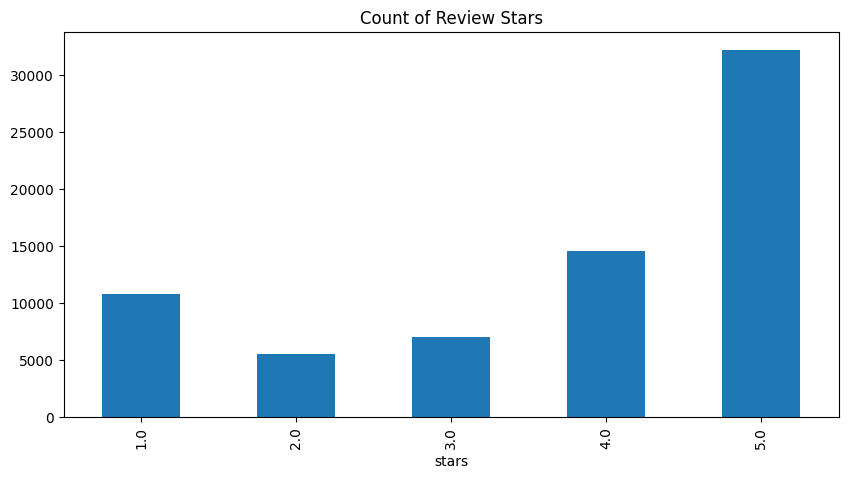

In [8]:
ax = df['stars'].value_counts().sort_index().plot(kind='bar',
                                          title='Count of Review Stars',
                                          figsize=(10,5))

plt.show()

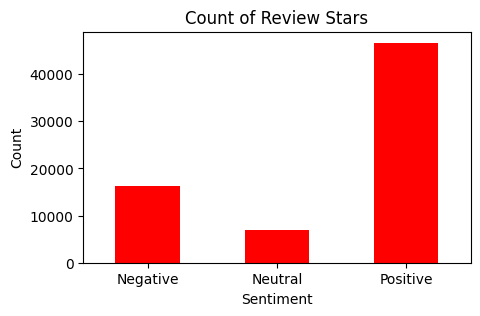

In [6]:
# Count the occurrences of each label
ax = df['target'].value_counts().sort_index().plot(kind='bar',
                                                  title='Count of Review Stars',
                                                  figsize=(5,3),
                                                  color='r')

# Customize labels
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'], rotation=0)

plt.show()


Dataset reduced for compatiblity

69903

## Data Preparation

In [9]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['target'])

test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['target'])

train_df.to_csv('train_set.csv', index=False)
val_df.to_csv('val_set.csv', index=False)
test_df.to_csv('test_set.csv', index=False)

len(train_df), len(val_df), len(test_df)


(62912, 3496, 3495)

Parameters

In [12]:
vocab_size = 5000  # Vocabulary size (choose a number based on your dataset)
embedding_dim = 128  # Embedding vector size
max_length = 100  # Max length of a sentence
batch_size = 32
epochs = 10

In [13]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text'])

In [14]:
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
val_sequences = tokenizer.texts_to_sequences(val_df['text'])
test_sequences = tokenizer.texts_to_sequences(test_df['text'])

In [15]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')


In [16]:
y_train = train_df['target'].values
y_val = val_df['target'].values
y_test = test_df['target'].values

## LSTM

In [17]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(128, return_sequences=False),  # LSTM layer with 128 units
    Dropout(0.5),  # Dropout to avoid overfitting
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: Negative, Neutral, Positive
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [18]:
from tensorflow.keras.callbacks import CSVLogger
logger = CSVLogger('training_log.csv', append=False)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. Train the Model
history = model.fit(train_padded, y_train, 
                    validation_data=(val_padded, y_val), 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=2,
                    callbacks = logger)

Epoch 1/10
1966/1966 - 17s - 9ms/step - accuracy: 0.6687 - loss: 0.8378 - val_accuracy: 0.6679 - val_loss: 0.8271
Epoch 2/10
1966/1966 - 12s - 6ms/step - accuracy: 0.7738 - loss: 0.6033 - val_accuracy: 0.8281 - val_loss: 0.4466
Epoch 3/10
1966/1966 - 12s - 6ms/step - accuracy: 0.8457 - loss: 0.4205 - val_accuracy: 0.8484 - val_loss: 0.4058
Epoch 4/10
1966/1966 - 12s - 6ms/step - accuracy: 0.8566 - loss: 0.3723 - val_accuracy: 0.8510 - val_loss: 0.3952
Epoch 5/10
1966/1966 - 12s - 6ms/step - accuracy: 0.8694 - loss: 0.3331 - val_accuracy: 0.8447 - val_loss: 0.4187
Epoch 6/10
1966/1966 - 12s - 6ms/step - accuracy: 0.8800 - loss: 0.3026 - val_accuracy: 0.8501 - val_loss: 0.4288
Epoch 7/10
1966/1966 - 12s - 6ms/step - accuracy: 0.8944 - loss: 0.2686 - val_accuracy: 0.8444 - val_loss: 0.4970
Epoch 8/10
1966/1966 - 12s - 6ms/step - accuracy: 0.9070 - loss: 0.2360 - val_accuracy: 0.8473 - val_loss: 0.4911
Epoch 9/10
1966/1966 - 12s - 6ms/step - accuracy: 0.9197 - loss: 0.2082 - val_accuracy: 

In [21]:
model.save("LSTM_senti.h5")

## Results

In [22]:
test_loss, test_acc = model.evaluate(test_padded, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8462 - loss: 0.5704
Test Loss: 0.5974648594856262, Test Accuracy: 0.8389127254486084


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


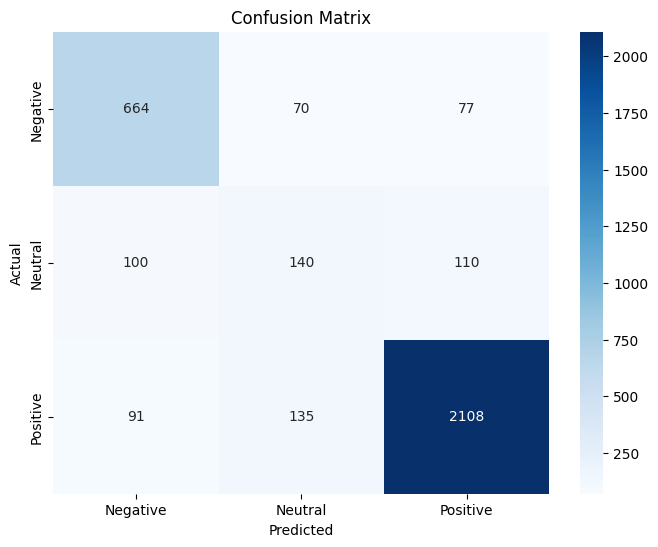

              precision    recall  f1-score   support

    Negative       0.78      0.82      0.80       811
     Neutral       0.41      0.40      0.40       350
    Positive       0.92      0.90      0.91      2334

    accuracy                           0.83      3495
   macro avg       0.70      0.71      0.70      3495
weighted avg       0.83      0.83      0.83      3495



In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 1. Generate predictions
y_pred = np.argmax(model.predict(test_padded), axis=1)

# 2. Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 3. Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Optionally, print classification report for more detailed metrics
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))


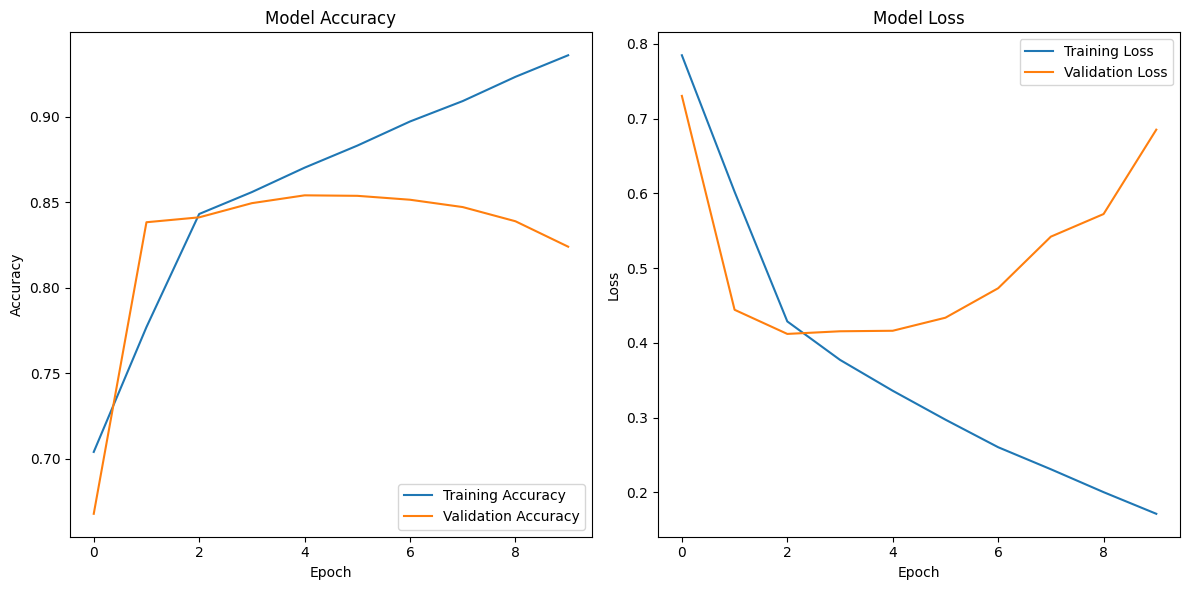

In [20]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned from model.fit()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# 1. Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# 2. Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Show the plots
plt.tight_layout()
plt.show()


In [21]:
# Assuming y_pred contains the predicted labels for the test dataset
y_pred = np.argmax(model.predict(test_padded), axis=1)
test_df['predicted'] = y_pred

test_df.to_csv('Predicted_test_set.csv', index=False)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [22]:
test_df.head(20)

,text,stars,target,predicted
65842,Seafood Parmigiana -- breaded shrimp topped wi...,3.0,1,1
32086,"I get my hair cut, colored and go there for bl...",5.0,2,2
896,Best staff ever! I've been going here since 20...,5.0,2,2
42498,By far my favorite Starbucks! I've been going ...,5.0,2,2
38810,For a first experience in New Orleans I can't ...,4.0,2,2
58370,Well got basically a response that they will r...,1.0,0,0
2684,The is the ONLY place for cupcakes. I'm in gr...,5.0,2,2
2339,Came here on a Saturday morning to grab some b...,2.0,0,0
59211,I've been getting my hair done by Roxy ever si...,5.0,2,2
25980,"Tabitha, the bartender at Bourbon Heat, recomm...",5.0,2,2


In [14]:
train_df

,text,stars,target
19463,This place was really nice. I've been passing ...,4.0,NaN
55471,Nice looking place. But once you get inside th...,1.0,NaN
29161,"Impressive selection and great ambience, total...",3.0,NaN
44624,I walked in not knowing you need an appointmen...,1.0,NaN
39587,I had the poboy and my gf had the gumbo both w...,5.0,NaN
...,...,...,...
69507,This is a nice quiet place to get good sushi. ...,4.0,NaN
7020,The one star is for the super rude service. Gr...,1.0,NaN
55177,"I had to try Nashville's hot chicken, so I ord...",4.0,NaN
51707,"We are longtime Vinnys2 customers, the food es...",5.0,NaN


## Inferncing Pipeline

In [2]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 67.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 92.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    Uninstalling urllib3-1.26.18:
      Successfully uninstalled urllib3-1.26.18
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.13.2
    Uninstalling tomlkit-0.13.2:
      Successfully uninstalled tomlkit-0.13.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2024.7.1 requires dask==2024.7.1, but you have dask 2024.8.1 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have goo

In [3]:
import gradio as gr

In [44]:
def Infernce_Pipe(text):
    model = tf.keras.models.load_model("/kaggle/working/LSTM_senti.h5")
    text = [text]
    sequences = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
   
    pred = model.predict(padded)
    predicted_index = np.argmax(pred)
    # Define the label mapping
    labels = ['Negative', 'Neutral', 'Positive']

    # Map index to label
    predicted_label = labels[predicted_index]

    return predicted_label

In [45]:
Infernce_Pipe("The service at this restaurant was exceptional, and the food was absolutely delicious!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Predicted label: Positive


'Positive'

In [1]:
# Define the Gradio interface
interface = gr.Interface(
    fn=Infernce_Pipe,                      # Function to call for prediction
    inputs=gr.Textbox(lines=2, placeholder="Enter text here..."),  # Textbox for user input
    outputs=gr.Text(label="Prediction"),  # Text output
    title="Sentiment Analysis",            # Title of the interface
    description="Enter a review to get its sentiment classification (negative, neutral, positive)."  # Description
)

# Launch the interface
interface.launch()


NameError: name 'gr' is not defined